In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalCntrees

In [21]:
corr = 0.

# Load Model

In [22]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze")
#model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze_bigger_models", 'layer4')


epoch=32-val_loss=0.000378.ckpt


In [23]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [24]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


/tmp/ipykernel_2288011/443524507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [25]:
n_eval_envs = -1 #50
traj_horizon = 800

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


# Run Model

In [26]:
query_type = 'root'

In [27]:
def get_results(query_offset, test_type, mask_type, buffer_matching_type, layer_strategy):

    results = {
        'cross_entropy_loss': [],
        'mask_layer': [],
        'mask_path_loc': [],
        'env': []
    }
    baseline_xc_losses = []
    for i_eval in range(n_eval_envs):
        env_acc = []
        baseline_env_acc = []
        traj = eval_trajs[i_eval]
        if traj['context_rewards'][:traj_horizon].sum().item() == 0:
            continue
        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': 10,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        optimal_action_map, dist_from_goal = env.make_opt_action_dict()
    
        # Choose query state
        if query_type == 'root':
            valid_query_states = [np.array(env.root.encoding())]
        elif query_type in ['far', 'middle']:
            valid_query_states = []
            for i in range(len(traj['context_states'])):
                if traj['context_states'][i].tolist() == list(env.root.encoding()):
                    continue
                d = dist_from_goal[tuple(traj['context_states'][i].tolist())]
                if query_type == 'far' and d < 12:
                    continue
                elif query_type == 'middle' and d != 6:
                   continue
                valid_query_states.append(traj['context_states'][i])
        if len(valid_query_states) == 0:
            print('No valid query states found')
            continue
        else:
            query_state = valid_query_states[np.random.choice(len(valid_query_states))]
    
        # Collect states on path from query state to goal
        s = query_state.tolist()
        states_on_path = [s]
        while True:
            action = np.zeros(4)
            action[optimal_action_map[tuple(s)]] = 1
            s, _ = env.transit(s, action)
            states_on_path.append(s)
            if np.array_equal(s, env.goal):
                break
        seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states'][:traj_horizon]))
        seen_states = np.unique(seen_states, axis=0) 
    
        # Check that every state in states_on_path is present in seen_states
        skip_env = False
        for state in states_on_path:
            if not any(np.array_equal(state, seen_state) for seen_state in seen_states):
                skip_env = True
                break
        if skip_env:
            continue
    
        # Prepare batch and optimal action information
        query_state = np.array(states_on_path[query_offset])
        batch = {
            'context_states': np.array(traj['context_states'][:traj_horizon]),
            'context_actions': np.array(traj['context_actions'][:traj_horizon]),
            'context_next_states': np.array(traj['context_next_states'][:traj_horizon]),
            'context_rewards': np.array(traj['context_rewards'][:traj_horizon])[:, None],
            'query_states': np.array(query_state),
            }
        batch['zeros'] = torch.zeros(10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            batch[k] = convert_to_tensor([batch[k]]).to(model.device)
        optimal_action = optimal_action_map[tuple(query_state.tolist())]
        optimal_action_tensor = torch.zeros(4).to(model.device)
        optimal_action_tensor[optimal_action] = 1
    
        # Get baseline loss
        with torch.no_grad():
            out = model(batch).squeeze()
        first_reward_idx = np.argwhere(traj['context_rewards'][:traj_horizon] == 1)[0,0]
        baseline_xc_loss = torch.nn.functional.cross_entropy(out, optimal_action_tensor).item()
        baseline_xc_losses.append(baseline_xc_loss)
    
        # Get loss with token attention masking
        for path_loc, s in enumerate(states_on_path):  # For each state on the path
            s_indices = []
            for i in range(traj_horizon):
                if buffer_matching_type == 'all':
                    if np.array_equal(s, traj['context_states'][i]) or np.array_equal(s, traj['context_next_states'][i]):
                        s_indices.append(i)
                elif buffer_matching_type == 'stay':
                    if np.array_equal(s, traj['context_states'][i]) and np.array_equal(s, traj['context_next_states'][i]):
                        s_indices.append(i)
                elif buffer_matching_type == 'exclude_stay':
                    if np.array_equal(s, traj['context_states'][i]) ^ np.array_equal(s, traj['context_next_states'][i]):
                        s_indices.append(i)
                elif buffer_matching_type == 'exclude_stay_prereward':
                    if np.array_equal(s, traj['context_states'][i]) ^ np.array_equal(s, traj['context_next_states'][i]):
                        if i < first_reward_idx:
                            s_indices.append(i)
                elif buffer_matching_type == 'exclude_stay_postreward':
                    if np.array_equal(s, traj['context_states'][i]) ^ np.array_equal(s, traj['context_next_states'][i]):
                        if i > first_reward_idx:
                            s_indices.append(i)
                elif buffer_matching_type == 'outof':
                    if np.array_equal(s, traj['context_states'][i]) and not np.array_equal(s, traj['context_next_states'][i]):
                        s_indices.append(i)
                elif buffer_matching_type == 'into':
                    if not np.array_equal(s, traj['context_states'][i]) and np.array_equal(s, traj['context_next_states'][i]):
                        s_indices.append(i)
                elif buffer_matching_type == 'onpath':
                    next_state_idx = min(path_loc+1, len(states_on_path)-1)
                    if np.array_equal(s, traj['context_states'][i]) and np.array_equal(states_on_path[next_state_idx], traj['context_next_states'][i]):
                        s_indices.append(i)
                elif buffer_matching_type == 'offpath':
                    next_state_idx = min(path_loc+1, len(states_on_path)-1)
                    if not (np.array_equal(s, traj['context_states'][i]) and np.array_equal(states_on_path[next_state_idx], traj['context_next_states'][i])):
                        s_indices.append(i)
                else:
                    raise ValueError(f"Invalid buffer matching type: {buffer_matching_type}")
            if len(s_indices) == 0:
                continue
            s_indices = torch.tensor(s_indices)
            s_indices_mask = torch.zeros(traj_horizon+1).bool()
            s_indices_mask[s_indices] = True
            if test_type == 'sufficiency':
                s_indices_mask = ~s_indices_mask
            elif test_type == 'necessity':
                s_indices_mask = s_indices_mask
            else:
                raise ValueError(f"Invalid test type: {test_type}")
            state_mask = torch.ones((traj_horizon+1, traj_horizon+1))  # Create a mask for the state
            if mask_type == 'all':
                state_mask[:, s_indices_mask] = 0
            elif mask_type == 'buffer':
                state_mask[:-1, s_indices_mask] = 0
            elif mask_type == 'query':
                state_mask[-1, s_indices_mask] = 0
            else:
                raise ValueError(f"Invalid mask type: {mask_type}")
            state_mask = torch.tril(state_mask)
            state_mask = state_mask.bool().to(model.device)
    
            for b in model.transformer.h:
                b._additional_attention_mask = None
    
            for l in range(model.n_layer):  # Apply the mask to each layer
                model.transformer.h[l]._additional_attention_mask = state_mask
                with torch.no_grad():
                    out = model(batch).squeeze()
                intervened_xc_loss = torch.nn.functional.cross_entropy(out, optimal_action_tensor).item()
                results['cross_entropy_loss'].append(baseline_xc_loss - intervened_xc_loss)
                results['mask_layer'].append(l)
                results['mask_path_loc'].append(path_loc)
                results['env'].append(i_eval)
                if layer_strategy == 'cumulative':
                    pass
                elif layer_strategy == 'single':
                    model.transformer.h[l]._additional_attention_mask = None
                else:
                    raise ValueError('Unknown layer strategy')

    return results

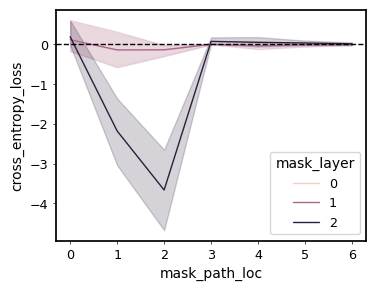

In [28]:
results = get_results(1, 'necessity', 'query', 'exclude_stay_postreward', 'cumulative')
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(
    x='mask_path_loc', y='cross_entropy_loss', hue='mask_layer',
    data=df,
    ax=ax)
ax.axhline(0, linestyle='--', color='black')

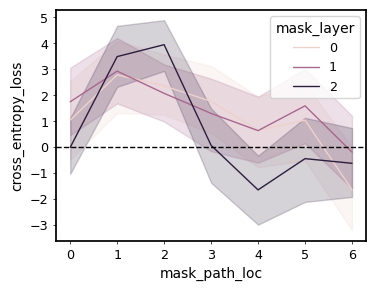

In [29]:
results = get_results(1, 'sufficiency', 'query', 'exclude_stay_postreward', 'cumulative')
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(
    x='mask_path_loc', y='cross_entropy_loss', hue='mask_layer',
    data=df,
    ax=ax)
ax.axhline(0, linestyle='--', color='black')

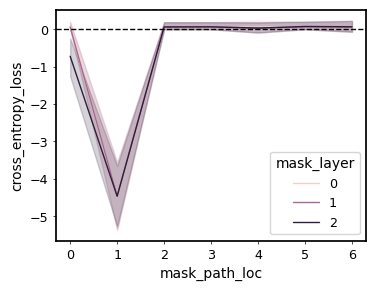

In [31]:
results = get_results(1, 'necessity', 'query', 'onpath', 'cumulative')
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(
    x='mask_path_loc', y='cross_entropy_loss', hue='mask_layer',
    data=df,
    ax=ax)
ax.axhline(0, linestyle='--', color='black')

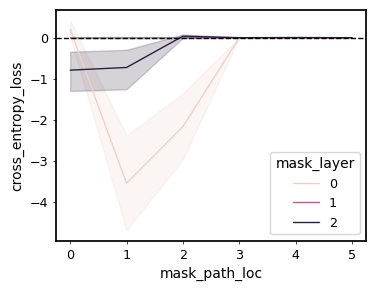

In [32]:
results = get_results(1, 'necessity', 'query', 'exclude_stay_prereward', 'single')
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(
    x='mask_path_loc', y='cross_entropy_loss', hue='mask_layer',
    data=df,
    ax=ax)
ax.axhline(0, linestyle='--', color='black')

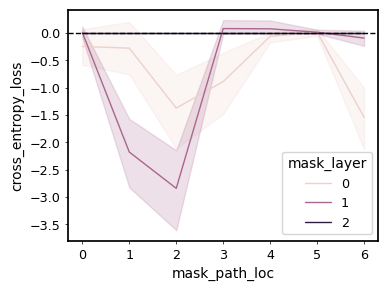

In [33]:
results = get_results(1, 'necessity', 'buffer', 'all', 'single')
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(
    x='mask_path_loc', y='cross_entropy_loss', hue='mask_layer',
    data=df,
    ax=ax)
ax.axhline(0, linestyle='--', color='black')